In [1]:
import os
import time
import csv
import signal
import random
import itertools
from tqdm import tqdm

from concurrent.futures import ProcessPoolExecutor, TimeoutError
from rasengan.problems.facility_location_problem import generate_flp
import numpy as np
from rasengan.solvers.optimizers import CobylaOptimizer
from rasengan.solvers.qiskit import (
    HeaSolver, PenaltySolver, ChocoSolver, RasenganSegmentedSolver, 
    FakeKyivProvider, FakeBrisbaneProvider,

)
np.random.seed(0x7f)
random.seed(0x7f)

In [2]:
noisy_csv_path = "fake_evaluate.csv"
num_cases = 10
flp_problems_pkg, flp_configs_pkg = generate_flp(num_cases, [(1, 2)], 1, 10)
problems_pkg = list(
    itertools.chain(
        enumerate(flp_problems_pkg),
    )
)

solvers = [HeaSolver, PenaltySolver, ChocoSolver, RasenganSegmentedSolver]
evaluation_metrics = ['best_solution_probs', 'in_constraints_probs', 'ARG', 'iteration_count', 'classcial', 'quantum', 'run_times']
headers = ['pkid', 'pbid', 'layers', "variables", 'constraints', 'method', 'fake_device'] + evaluation_metrics
fake_devices = [FakeKyivProvider, FakeBrisbaneProvider]

def process_layer(prb, num_layers, solver, fake_device):
    opt = CobylaOptimizer(max_iter=50)
    fake_provider = fake_device()
    prb.set_penalty_lambda(400)
    solver_args = dict(
        prb_model=prb,
        optimizer=opt,
        provider=fake_provider,
        num_layers=num_layers,
        shots=1024,
    )
    if solver == RasenganSegmentedSolver:
        solver_args["num_segments"] = 1000
    used_solver = solver(**solver_args)
    used_solver.solve()
    eval = used_solver.evaluation()
    time = list(used_solver.time_analyze())
    run_times = used_solver.run_counts()
    return eval + time + [run_times]

if __name__ == '__main__':
    print("Evaluating ARG:")
    all_start_time = time.perf_counter()
    set_timeout = 60 * 60 * 24 * 10 # Set timeout duration
    num_complete = 0
    # print(amp_csv_path)
    with open(f'{noisy_csv_path}', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write headers once

    num_processes_cpu = os.cpu_count()
    num_processes = num_processes_cpu // 4
    # pkid-pbid: 问题包序-包内序号
    for pkid, (diff_level, problems) in enumerate(problems_pkg):
        for fake_device_idx in range(len(fake_devices)):
            for solver_idx in range(len(solvers)):
                with ProcessPoolExecutor(max_workers=num_processes) as executor:
                    futures = []
                    layer = 5
                    for pbid, prb in enumerate(problems):
                        # Bug in the retrieval of Python class names
                        fake_device = fake_devices[fake_device_idx]
                        device_name = fake_device.__name__
                        solver = solvers[solver_idx]
                        solver_name = solver.__name__
                        future = executor.submit(process_layer, prb, layer, solver, fake_device)
                        futures.append((future, prb, pkid, pbid, layer, solver_name, device_name))

                
                    start_time = time.perf_counter()
                    for future, prb, pkid, pbid, layer, solver, fake_device in tqdm(futures, desc=f"{solver_name} on {device_name}"):
                        current_time = time.perf_counter()
                        remaining_time = max(set_timeout - (current_time - start_time), 0)
                        diff = []
                        try:
                            metrics = future.result(timeout=remaining_time)
                            diff.extend(metrics)
                            # print(f"Task for problem {pkid}-{pbid} L={layer} {solver} executed successfully.")
                        except MemoryError:
                            print(f"Task for problem {pkid}-{pbid} L={layer} {solver} encountered a MemoryError.")
                            for dict_term in evaluation_metrics:
                                diff.append('memory_error')
                        except TimeoutError:
                            print(f"Task for problem {pkid}-{pbid} L={layer} {solver} timed out.")
                            for dict_term in evaluation_metrics:
                                diff.append('timeout')
                        except Exception as e:
                            print(f"An error occurred: {e}")
                        finally:
                            row = [pkid, pbid, layer, len(prb.variables), len(prb.lin_constr_mtx), solver, fake_device] + diff
                            with open(f'{noisy_csv_path}', mode='a', newline='') as file:
                                writer = csv.writer(file)
                                writer.writerow(row)  # Write row immediately
                            num_complete += 1
                            if num_complete == len(futures):
                                # print(f'problem_pkg_{pkid} has finished')
                                for process in executor._processes.values():
                                    os.kill(process.pid, signal.SIGTERM)
    print(f'Data has been written to {noisy_csv_path}')
    print(f"Time elapsed: {time.perf_counter() - all_start_time:.2f}s")

Evaluating ARG:


RasenganSegmentedSolver on FakeBrisbaneProvider: 100%|██████████| 10/10 [16:03<00:00, 96.35s/it]  

Data has been written to fake_evaluate.csv
Time elapsed: 3518.38s


In [3]:
import pandas as pd

pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
fake_evaluate_csv_path = 'fake_evaluate.csv'
df = pd.read_csv(fake_evaluate_csv_path)
df_avg = df.groupby(['method', 'fake_device'], as_index=False).agg({
    'ARG': ['mean', 'std'], 
    'in_constraints_probs': ['mean', 'std']
})


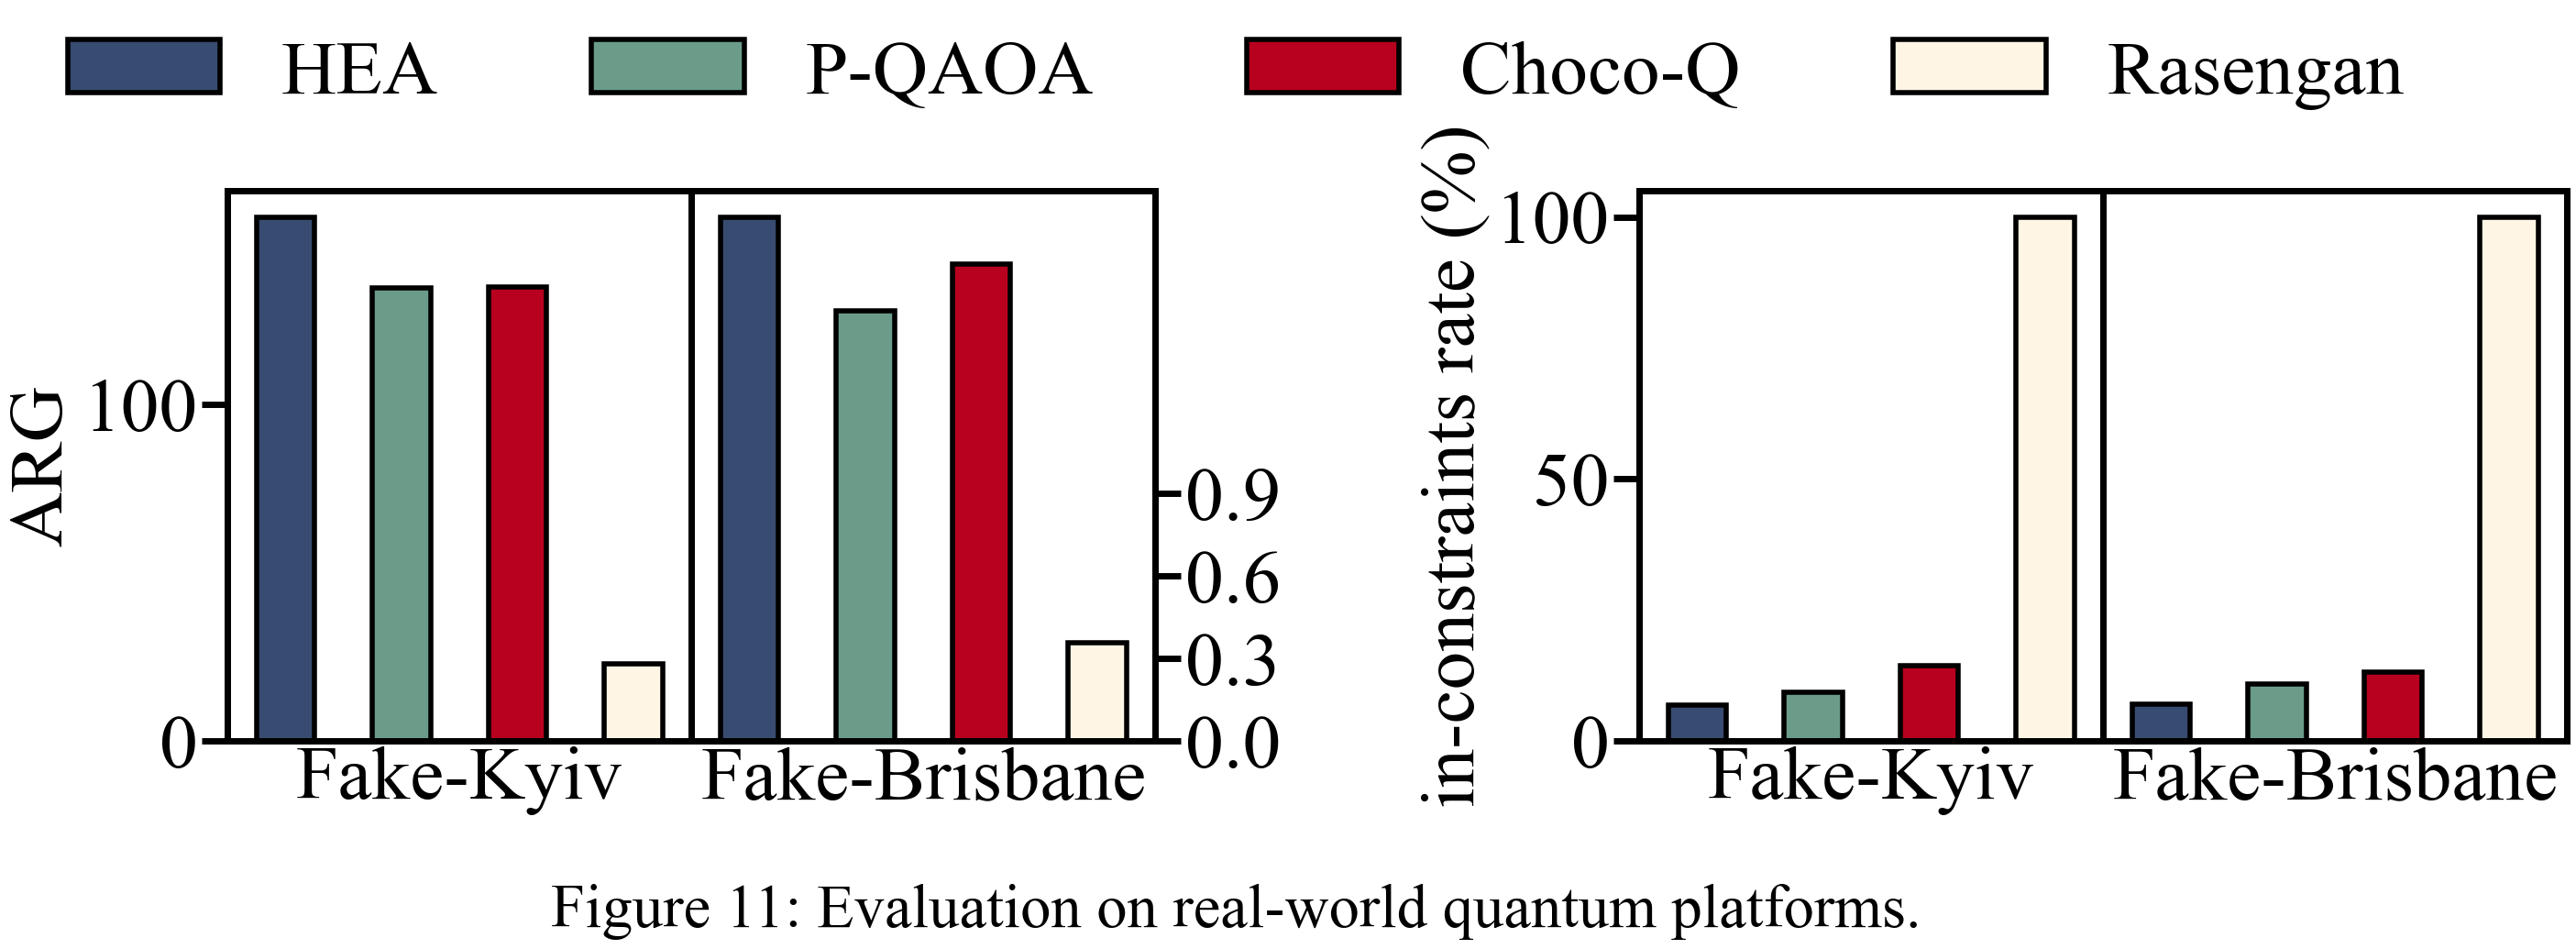

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Initialize the figure and axis settings
scale = 1
fig = plt.figure(figsize=(22 * scale, 12 * scale))

mpl.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Times New Roman',
    'font.size': 60,
    'axes.unicode_minus': False,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'axes.linewidth': 5,
    'xtick.major.size': 20,
    'xtick.major.width': 5,
    'xtick.minor.size': 10,
    'xtick.minor.width': 3,
    'ytick.major.size': 20,
    'ytick.major.width': 5,
    'ytick.minor.size': 10,
    'ytick.minor.width': 3,
    "lines.markersize": 35,
    "lines.markeredgewidth": 4,
    "markers.fillstyle": 'full',
    'lines.markerfacecolor': '#f8d941',
    'lines.markeredgecolor': 'black',
})

methods = ["HeaSolver", "PenaltySolver", "ChocoSolver", "RasenganSegmentedSolver"]
fake_devices = ['FakeKyivProvider', 'FakeBrisbaneProvider']
fake_device_names = ['Fake-Kyiv', 'Fake-Brisbane']
metrics = ['ARG', 'in_constraints_probs']

move = 0.2
visible_bar_width = 0.1
colors = ['#384B70', '#6A9C89', '#B8001F', '#FFF5E4']

for i, fake_device in enumerate(fake_devices):
    for j, metric in enumerate(metrics):
        ax = fig.add_axes((j * 0.7 + i * 0.23, 0, 0.23, 0.5))

        for idx, method in enumerate(methods):
            data = df_avg[df_avg['fake_device'] == fake_device]
            method_data = data[data['method'] == method]
            y = method_data[metric]['mean'].values.tolist()

            x_pos = idx * move

            if method == "RasenganSegmentedSolver":
                ax2 = ax.twinx()
                ax2.bar(
                    x_pos, y, visible_bar_width, color=colors[idx], 
                    edgecolor="black", label=method, linewidth=4,
                )

                if j == 0:
                    ax2.set_ylim(0, 2)
                else:
                    ax2.set_ylim(0, 105)

                if i == 1 and j == 0:
                    ax2.set_yticks([x / 10 for x in range(0, 10, 3)])
                else:
                    ax2.set_yticks([])

            else:
                ax.bar(
                    x_pos, y, visible_bar_width, color=colors[idx],
                    edgecolor="black", label=method, linewidth=4,
                )

        ax.set_xticks([])
        ax.set_xlim(-0.1, 0.7)
        ax.set_xlabel(fake_device_names[i])

        if j == 1:
            ax.set_ylim(0, 105)
        if i == 0:
            ax.set_ylabel('ARG' if j == 0 else 'in-constraints rate (%)')
        else:
            ax.set_yticks([])

# 图例
fig.legend(
    labels=["HEA", "P-QAOA", "Choco-Q", "Rasengan"],
    frameon=False,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.7),
    ncol=4
)

title = "Figure 11: Evaluation on real-world quantum platforms"
plt.suptitle(title, y=-0.13, fontsize=48)
plt.savefig(f'{title}.svg', bbox_inches='tight')
plt.show()